In [10]:
import pyemu
import os, shutil
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import geostat_helpers as gh
import pandas as pd
from scipy.stats.mstats import normaltest
import scipy.stats as sps

# Geostatistics 
### Some definitions from Geoff Bohling http://people.ku.edu/~gbohling/cpe940/Variograms.pdf
> ## “Geostatistics: study of phenomena that vary in space and/or time”
(Deutsch, 2002)


> ## “Geostatistics can be regarded as a collection of numerical techniques that deal with the characterization of spatial attributes, employing primarily random models in a manner similar to the way in which time series analysis characterizes temporal data.”
(Olea, 1999)


> ## “Geostatistics offers a way of describing the spatial continuity of natural phenomena and provides adaptations of classical regression techniques to take advantage of this continuity.” 
(Isaaks and Srivastava, 1989)


> ## Geostatistics deals with spatially _autocorrelated_ data.

> ## Autocorrelation: correlation between elements of a series and others from the same series separated from them by a given interval. 
(Oxford American Dictionary)

# Main Concepts


## 1. Variogram modeling -- a way to characterize spatial correlation
## 2. Kriging -- a best linear unbiased estimate (BLUE) for interpolation with minimum variance. There are several flavors - we will focus on Ordinary Kriging
## 3. Stochastic Simulation -- http://petrowiki.org/Geostatistical_conditional_simulation
## 4. Beyond this multi-Gaussian approach focused on the relationships among pairs of points, there is _multiple point geostatistics_ as well using training images and more complex shapes

# These concepts each build on each other. We will briefly touch on the first two

## let's cook up a quick random field and explore the spatial structure

In [ ]:
X,Y,Z,v,gs,sample_df = gh.data_cooker()

## Pretend (key word!) that this is a hydraulic conductivity field

## Any _autocorrelation_ here?

In [ ]:
gh.grid_plot(X,Y,Z)

## Of course, we would typically only know the values at a few points 
## (and probably not perfectly)
## N.B. --> The default number of samples used here is 50

In [ ]:
gh.field_scatterplot(sample_df.x,sample_df.y,sample_df.z)

====================================

# Geostatistics is based on a couple main assumptions:
   ## 1. The values are second order stationary (the mean and variance are relatively constant) 
   ## 2. The values are multi-Gaussian (e.g. normally distributed)

# Are the raw data normally distributed?

### Spoiler alert - this field was generated using a variogram!

In [ ]:
plt.hist(Z.ravel(), bins=50)
x=np.linspace(70,130,100)
plt.plot(x,sps.norm.pdf(x, np.mean(Z),np.std(Z))*len(Z.ravel()))

In [ ]:
normaltest(Z.ravel())

# How about our subsample?

In [ ]:
plt.hist(sample_df.z, bins=50)
x=np.linspace(70,130,100)
plt.plot(x,sps.norm.pdf(x, np.mean(sample_df.z),np.std(sample_df.z))*len(sample_df.z))

In [ ]:
normaltest(sample_df.z)

# That was a pretty small sample....
## Explore a bigger sample

In [ ]:
n_sample_pts=1000
xd = np.random.uniform(0, 1000, n_sample_pts)
yd = np.random.uniform(0, 1000, n_sample_pts)
z = gh.sample_from_grid(X,Y,Z,xd,yd)
plt.hist(z, bins=50)
x=np.linspace(70,130,100)
plt.plot(x,sps.norm.pdf(x, np.mean(z),np.std(z))*len(z))
normaltest(z)

## Purity is commendable, but we are going to violate some of these assumptions for sure

====================================

# At the heart of geostatistics is some kind of model expressing the variability of properties in a field

## This is a "variogram" and we can explore it based on the following empirical formula
## $\hat{\gamma}\left(h\right)=\frac{1}{2\left(h\right)}\left(z\left(x_1\right)-z\left(x_2\right)\right)^2$
## where $x_1$ and $x_2$ are the locations of two $z$ data points separated by distance $h$

## If we plot these up we get something called a cloud plot showing $\hat\gamma$ for all pairs in the dataset

In [ ]:
h,gam,ax=gh.plot_empirical_variogram(sample_df.x,sample_df.y,sample_df.z,0)

## This is pretty messy, so typically it is evaluated in bins, and usually only over half the total possible distance

In [ ]:
h,gam,ax=gh.plot_empirical_variogram(sample_df.x,sample_df.y,sample_df.z,50)

## Also note that this was assuming perfect observations. What if there was ~10% noise?

In [ ]:
h,gam,ax=gh.plot_empirical_variogram(sample_df.x,sample_df.y,sample_df.z_noisy,30)

## Geostatistics is making the assumption that you can model the variability of this field using a variogram. The variogram is closely related to covariance. 

## We take advantage of a few assumptions to come up with a few functional forms that should characterize this behavior

## `pyemu` supports three variogram models

## This follows the _GSLIB_ terminology

 ## 1. *Spherical*  
### $\gamma\left(h\right)=c\times\left[1.5\frac{h}{a}-0.5\frac{h}{a}^3\right]$ if $h<a$
### $\gamma\left(h\right)=c$ if $h \ge a$  
     
 ## 2. *Exponential*  
### $\gamma\left(h\right)=c\times\left[1-\exp\left(-\frac{h}{a}\right)\right]$  
     
 ## 3. *Gaussian*  
### $\gamma\left(h\right)=c\times\left[1-\exp\left(-\frac{h^2}{a^2}\right)\right]$  

     

### $h$ is the separation distance, and $a$ is the range. `contribution` is the variogram value at which the variogram levels off. Also called the `sill`, this value is the maximum variability between points.

### The sill is reached at about $a$ for the *Spherical* model, $2a$ for the *Gaussian*, and $3a$ for the *Exponential*

# What do these look like?

## for a consistent set of parameters:
## a=500, c=10
## We can use `pyemu` to setup a geostatistical model

In [ ]:
a=500
c=10

## Set up a variogram object and, from that, build a geostatistical structure

### _Spherical_

In [ ]:
v = pyemu.geostats.SphVario(contribution=c, a=a)
gs = pyemu.geostats.GeoStruct(variograms=v)

In [ ]:
gs.plot()
plt.plot([v.a,v.a],[0,v.contribution],'r')
plt.grid()

In [ ]:
Q= gs.covariance_matrix(X.ravel(), Y.ravel(), names=[str(i) for i in range(len(Y.ravel()))])
plt.figure(figsize=(6,6))
plt.imshow(Q.x)
plt.colorbar()

### _Exponential_

In [ ]:
v = pyemu.geostats.ExpVario(contribution=c, a=a)
gs = pyemu.geostats.GeoStruct(variograms=v)
gs.plot()
plt.plot([v.a,v.a],[0,v.contribution],'r')
plt.plot([3*v.a,3*v.a],[0,v.contribution],'r:')
plt.grid()

In [ ]:
Q= gs.covariance_matrix(X.ravel(), Y.ravel(), names=[str(i) for i in range(len(Y.ravel()))])
plt.figure(figsize=(6,6))
plt.imshow(Q.x)
plt.colorbar()

### _Gaussian_

In [ ]:
v = pyemu.geostats.GauVario(contribution=c, a=a)
gs = pyemu.geostats.GeoStruct(variograms=v)
gs.plot()
plt.plot([v.a,v.a],[0,v.contribution],'r')
plt.plot([7/4*v.a,7/4*v.a],[0,v.contribution],'r:')
plt.grid()

In [ ]:
Q= gs.covariance_matrix(X.ravel(), Y.ravel(), names=[str(i) for i in range(len(Y.ravel()))])
plt.figure(figsize=(6,6))
plt.imshow(Q.x)
plt.colorbar()

# If we fit an appropriate model ($\gamma$) to the empirical variogram ($\hat\gamma$), we can use that structure for interpolation from sparse data

In [ ]:
h,gam,ax=gh.plot_empirical_variogram(sample_df.x,sample_df.y,sample_df.z,50)
new_c=70.0
new_a=250.0

v_fit = pyemu.geostats.ExpVario(contribution=new_c,a=new_a)
gs_fit = pyemu.geostats.GeoStruct(variograms=v_fit)
gs_fit.plot(ax=ax)


In [ ]:
Q = gs_fit.covariance_matrix(X.ravel(), Y.ravel(), names=[str(i) for i in range(len(Y.ravel()))])

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(Q.x)
plt.colorbar()


# We can perform Kriging to interpolate using this variogram and our "data"

## First make an Ordinary Kriging object

In [ ]:
k = pyemu.geostats.OrdinaryKrige(gs_fit,sample_df)

In [ ]:
sample_df.head()

## Next we need to calculate factors (we only do this once - takes a few seconds)

In [ ]:
kfactors = k.calc_factors(X.ravel(),Y.ravel())

## It's easiest to think of these factors as weights on surrounding point to calculate a weighted average of the surrounding values. The weight is a function of the distance - farther points have smaller weights

In [ ]:
kfactors.head()

In [ ]:
Z_interp = gh.geostat_interpolate(X,Y,k.interp_data, sample_df)

In [ ]:
vlims = [Z.min(),Z.max()]
ax=gh.grid_plot(X,Y,Z_interp,vlims=vlims, title='reconstruction')
ax.plot(sample_df.x,sample_df.y, 'ko')

In [ ]:
gh.grid_plot(X,Y,Z,vlims=vlims,title='truth')

In [ ]:
ax=gh.grid_plot(X,Y,kfactors.err_var.values.reshape(X.shape), title='Variance of Estimate')
ax.plot(sample_df.x,sample_df.y, 'ko')

In [ ]:
ax=gh.grid_plot(X,Y,np.abs(Z-Z_interp), title='Actual Differences')
ax.plot(sample_df.x,sample_df.y, 'yo')

# What if our data were noisy?

In [ ]:
h,gam,ax=gh.plot_empirical_variogram(sample_df.x,sample_df.y,sample_df.z_noisy,30)
new_c=150.0
new_a=275.0

# select which kind of variogram here because in reality we don't know, right?
v_fit = pyemu.geostats.ExpVario(contribution=new_c,a=new_a)
gs_fit = pyemu.geostats.GeoStruct(variograms=v_fit, nugget=50)
gs_fit.plot(ax=ax)

In [ ]:
Q = gs_fit.covariance_matrix(X.ravel(), Y.ravel(), names=[str(i) for i in range(len(Y.ravel()))])
plt.figure(figsize=(6,6))
plt.imshow(Q.x)
plt.colorbar();

## Again make the Kriging Object and the factors and interpolate

In [ ]:
k = pyemu.geostats.OrdinaryKrige(gs_fit,sample_df)
kfactors = k.calc_factors(X.ravel(),Y.ravel())
Z_interp = gh.geostat_interpolate(X,Y,k.interp_data, sample_df)

In [ ]:
ax=gh.grid_plot(X,Y,Z_interp,vlims=vlims, title='reconstruction')
ax.plot(sample_df.x,sample_df.y, 'ko')

In [ ]:
gh.grid_plot(X,Y,Z,vlims=vlims,title='truth')

In [ ]:
ax=gh.grid_plot(X,Y,kfactors.err_var.values.reshape(X.shape), title='Variance of Estimate')
ax.plot(sample_df.x,sample_df.y, 'ko')

In [ ]:
ax=gh.grid_plot(X,Y,np.abs(Z-Z_interp), title='Actual Differences')
ax.plot(sample_df.x,sample_df.y, 'yo')

### Spectral simulation

Because pyemu is pure python (and because the developers are lazy), it only implments spectral simulation for grid-scale field generation.  For regular grids without anisotropy and without conditioning data ("known" property values), it is identical to sequential gaussian sim

In [ ]:
ev = pyemu.geostats.ExpVario(1.0,1)
gs = pyemu.geostats.GeoStruct(variograms=ev)
ss = pyemu.geostats.SpecSim2d(np.ones(100),np.ones(100),gs)
plt.imshow(ss.draw_arrays()[0])

In [ ]:
ev = pyemu.geostats.ExpVario(1.0,5)
gs = pyemu.geostats.GeoStruct(variograms=ev)
ss = pyemu.geostats.SpecSim2d(np.ones(100),np.ones(100),gs)
plt.imshow(ss.draw_arrays()[0])

In [ ]:
ev = pyemu.geostats.ExpVario(1.0,500)
gs = pyemu.geostats.GeoStruct(variograms=ev)
ss = pyemu.geostats.SpecSim2d(np.ones(100),np.ones(100),gs)
plt.imshow(ss.draw_arrays()[0])

# Further resources and information

   # These concepts are used for pilot point interpolation in PEST
   ## a. In the GW utilities in PEST (http://www.pesthomepage.org/Groundwater_Utilities.php) 
   ## b. The main tools are also available in `pyemu` -- we'll use that in the class

# A nice but outdated set of references is at: http://people.ku.edu/~gbohling/geostats/

# The Stanford Geostatistical Modeling Software (SGeMS: http://sgems.sourceforge.net/) is a nice GUI for geostatistical modeling, but it's not being maintained anymore.

# `R` has a package: http://rgeostats.free.fr/

# Some packages are under development in `python` but not very far along. 

# `QGIS` and `ArcGIS` have some geostatistical modeling capabilities as well

# Implementing Pilot Points in a `MODFLOW` model with `pyemu`

In [2]:
import flopy

In [3]:
t_d = "template_history"
m = flopy.modflow.Modflow.load("freyberg.nam",model_ws=t_d,check=False,forgive=False)

In [7]:
m.get_package_list()

['DIS', 'BAS6', 'UPW', 'NWT', 'OC', 'WEL', 'RCH', 'GHB', 'SFR']

## Set up zones for where pilot points will be interpolated

We can have pilot point networks in multiple zones. In this case, we will make a simple zone file using `IBOUND` such that all active cells are in the same interpolation zone.

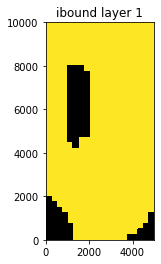

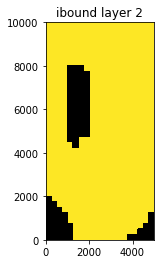

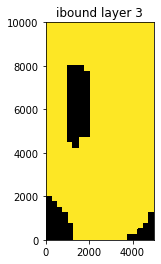

In [8]:
m.bas6.ibound.plot()

### We don't want pilot points or care about HK values in inactive cells, but we do need values in constant heads

We are going to use a `pyemu` helper function to setup pilot points are cell centers for active cells in layer 2.

In [11]:
working_dir = 'pp_tmp'
if os.path.exists(working_dir):
    shutil.rmtree(working_dir)
os.mkdir(working_dir)

In [53]:
# we want hk pilot points in the top layer...
prefix_dict = {1:["hk"]}  # note, layer 1 is the neew layer 2 (e.g. zero-based)
df_pp = pyemu.utils.setup_pilotpoints_grid(ml=m,prefix_dict=prefix_dict,
                                              pp_dir=working_dir,
                                              tpl_dir=working_dir,
                                              every_n_cell=6)
pp_file = os.path.join(working_dir,"hkpp.dat")
assert os.path.exists(pp_file)

In [54]:
df_pp

,name,x,y,zone,parval1,k,i,j,tpl,parnme,tpl_filename,pp_filename,pargp,partrans,parchglim,parlbnd,parubnd,scale,offset,dercom
0,pp_0000,875.0,9125.0,1.0,1.0,1,3,3,~ hk00 ~,hk00,pp_tmp/hkpp.dat.tpl,pp_tmp/hkpp.dat,hk,log,factor,1.100000e-10,1.100000e+10,1.0,0.0,1
1,pp_0001,2375.0,9125.0,1.0,1.0,1,3,9,~ hk01 ~,hk01,pp_tmp/hkpp.dat.tpl,pp_tmp/hkpp.dat,hk,log,factor,1.100000e-10,1.100000e+10,1.0,0.0,1
2,pp_0002,3875.0,9125.0,1.0,1.0,1,3,15,~ hk02 ~,hk02,pp_tmp/hkpp.dat.tpl,pp_tmp/hkpp.dat,hk,log,factor,1.100000e-10,1.100000e+10,1.0,0.0,1
3,pp_0003,875.0,7625.0,1.0,1.0,1,9,3,~ hk03 ~,hk03,pp_tmp/hkpp.dat.tpl,pp_tmp/hkpp.dat,hk,log,factor,1.100000e-10,1.100000e+10,1.0,0.0,1
4,pp_0004,2375.0,7625.0,1.0,1.0,1,9,9,~ hk04 ~,hk04,pp_tmp/hkpp.dat.tpl,pp_tmp/hkpp.dat,hk,log,factor,1.100000e-10,1.100000e+10,1.0,0.0,1
5,pp_0005,3875.0,7625.0,1.0,1.0,1,9,15,~ hk05 ~,hk05,pp_tmp/hkpp.dat.tpl,pp_tmp/hkpp.dat,hk,log,factor,1.100000e-10,1.100000e+10,1.0,0.0,1
6,pp_0006,875.0,6125.0,1.0,1.0,1,15,3,~ hk06 ~,hk06,pp_tmp/hkpp.dat.tpl,pp_tmp/hkpp.dat,hk,log,factor,1.100000e-10,1.100000e+10,1.0,0.0,1
7,pp_0007,2375.0,6125.0,1.0,1.0,1,15,9,~ hk07 ~,hk07,pp_tmp/hkpp.dat.tpl,pp_tmp/hkpp.dat,hk,log,factor,1.100000e-10,1.100000e+10,1.0,0.0,1
8,pp_0008,3875.0,6125.0,1.0,1.0,1,15,15,~ hk08 ~,hk08,pp_tmp/hkpp.dat.tpl,pp_tmp/hkpp.dat,hk,log,factor,1.100000e-10,1.100000e+10,1.0,0.0,1
9,pp_0009,875.0,4625.0,1.0,1.0,1,21,3,~ hk09 ~,hk09,pp_tmp/hkpp.dat.tpl,pp_tmp/hkpp.dat,hk,log,factor,1.100000e-10,1.100000e+10,1.0,0.0,1


## Need to create Kriging factors and regularization inputs
Following the guidelines in _Approaches to Highly Parameterized Inversion: Pilot-Point Theory, Guidelines, and Research Directions_ https://pubs.usgs.gov/sir/2010/5168/

### First, let's create ``variogram`` and ``GeoStruct`` objects.  

These describe how HK varies spatailly, remember?

(0, 2.0)

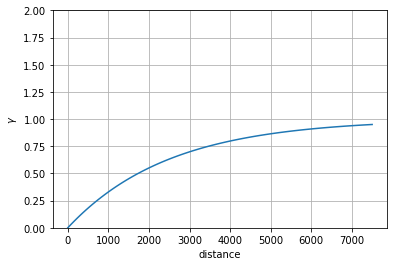

In [55]:
v = pyemu.geostats.ExpVario(contribution=1.0,a=2500)
gs = pyemu.geostats.GeoStruct(variograms=v,nugget=0.0)
ax = gs.plot()
ax.grid()
ax.set_ylim(0,2.0)

Now, let's get an ``OrdinaryKrige`` object, which needs the ``GeoStruct`` as well as the x, y, and name of the pilot point locations (which happens to be in that really cool ``df_pp`` instance)

In [56]:
ok = pyemu.geostats.OrdinaryKrige(gs,df_pp)

Once the ``OrdinaryKrige`` is created, we need to calculate the geostatistical interpolation factors for each model cell.  We do this with the ``.calc_factors_grid()`` method: it needs to know about the model's spatial orientation and also accepts some optional arguments:

In [57]:
df = ok.calc_factors_grid(m.sr,var_filename=os.path.join(working_dir,'kriging.var'),minpts_interp=1,maxpts_interp=10)

starting interp point loop for 800 points
took 4.397599 seconds


One of the really cool things about geostatistics is that it gives you both the interpolation (factors), but also gives you the uncertainty in the areas between control (pilot) points.  Above, we wrote this uncertainty information to an array that has the same rows and cols as the model grid - this array is very useful for understanding the function of the variogram.

Text(0.5, 1.0, 'Kriging Variance')

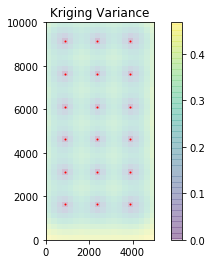

In [58]:
# plot the kriging variance
arr_var = np.loadtxt(os.path.join(working_dir,'kriging.var'))
ax = plt.subplot(111,aspect="equal")
p = ax.imshow(arr_var,extent=m.sr.get_extent(),alpha=0.25)
plt.colorbar(p)
ax.scatter(df_pp.x,df_pp.y,marker='.',s=4,color='r')
ax.set_title('Kriging Variance')

We see that at the pilot point locations (red dots), the uncertainty in the geostats is minimal...as expected. The call to ``.calc_factors_grid()`` also returns a ``DataFrame`` which has useful info - lets look:

In [59]:
df

,x,y,idist,inames,ifacts,err_var
0,125.0,9875.0,"[1060.6601717798212, 2371.7082451262845, 2371.7082451262845, 3181.9805153394636, 3824.2646351945...","[pp_0000, pp_0001, pp_0003, pp_0004, pp_0002, pp_0006, pp_0005, pp_0007, pp_0009, pp_0008]","[0.6727583738647903, 0.06386537976519578, 0.06490211746549873, -0.045564991330796584, 0.07034822...",0.356100
1,375.0,9875.0,"[901.3878188659974, 2136.000936329383, 2304.886114323222, 3010.398644698074, 3579.4552658190883,...","[pp_0000, pp_0001, pp_0003, pp_0004, pp_0002, pp_0006, pp_0005, pp_0007, pp_0008, pp_0009]","[0.7071753569517559, 0.08444690004700789, 0.04013466527629428, -0.042635731616081335, 0.06549296...",0.321503
2,625.0,9875.0,"[790.5694150420949, 1903.943276465977, 2263.8462845343543, 2850.438562747845, 3335.4160160315832...","[pp_0000, pp_0001, pp_0003, pp_0004, pp_0002, pp_0006, pp_0005, pp_0007, pp_0008, pp_0009]","[0.7231412089011208, 0.11807249676348981, 0.016211260883993266, -0.039241829327129, 0.0622125570...",0.295673
3,875.0,9875.0,"[750.0, 1677.0509831248423, 2250.0, 2704.163456597992, 3092.3292192132453, 3750.0, 3750.0, 4038....","[pp_0000, pp_0001, pp_0003, pp_0004, pp_0002, pp_0005, pp_0006, pp_0007, pp_0008, pp_0009]","[0.7074061465278885, 0.17037130042169, -0.001655943536703744, -0.03564888961025468, 0.0615110028...",0.287354
4,1125.0,9875.0,"[790.5694150420949, 1457.7379737113251, 2263.8462845343543, 2573.9075352467503, 2850.43856274784...","[pp_0000, pp_0001, pp_0003, pp_0004, pp_0002, pp_0005, pp_0006, pp_0007, pp_0008, pp_0009]","[0.6535002032511142, 0.24351952153343823, -0.010489495462947968, -0.03252797911282037, 0.0643799...",0.297414
...,...,...,...,...,...,...
795,3875.0,125.0,"[1500.0, 2121.3203435596424, 3000.0, 3354.1019662496847, 3354.1019662496847, 4242.640687119285, ...","[pp_0017, pp_0016, pp_0014, pp_0015, pp_0013, pp_0012, pp_0011, pp_0010, pp_0009, pp_0008]","[0.5313967335663956, 0.20458721027576401, 0.007517657944844111, 0.12025406437700523, -0.05084980...",0.428144
796,4125.0,125.0,"[1520.690632574555, 2304.886114323222, 3010.398644698074, 3473.110997362451, 3579.4552658190883,...","[pp_0017, pp_0016, pp_0014, pp_0013, pp_0015, pp_0012, pp_0011, pp_0010, pp_0009, pp_0008]","[0.5481830730623114, 0.16876411381177941, 0.01711598726416538, -0.050824397541397566, 0.11418340...",0.432612
797,4375.0,125.0,"[1581.1388300841897, 2500.0, 3041.38126514911, 3605.5512754639894, 3807.886552931954, 4527.69256...","[pp_0017, pp_0016, pp_0014, pp_0013, pp_0015, pp_0011, pp_0012, pp_0010, pp_0009, pp_0008]","[0.5522925934812123, 0.13910787323446516, 0.028681557251145472, -0.050980883779019964, 0.1108582...",0.441264
798,4625.0,125.0,"[1677.0509831248423, 2704.163456597992, 3092.3292192132453, 3750.0, 4038.873605350878, 4562.0718...","[pp_0017, pp_0016, pp_0014, pp_0013, pp_0015, pp_0011, pp_0012, pp_0010, pp_0009, pp_0008]","[0.545661440142163, 0.11561620703186092, 0.0412726373886524, -0.051193957721705395, 0.1096242353...",0.453497


We see that there is one row for each model cell, and for each row, we see the distance, names, and weight for the "nearby" pilot points.  The interpolated value for cells that have a pilot point at their center only need one weight - 1.0 - and one pilot point.  Other cells are weighted combinations of pilot points.  Is this clear?  

Now we need to save the factors (weights) to a special file that we will use later to quickly generate a new HK array from a set of pilot point values:

In [60]:
ok.to_grid_factors_file(pp_file+".fac")

In [61]:
pp_file

'pp_tmp/hkpp.dat'

Just for demo purposes, lets generate ``random`` pilot point values and run them through the factors to see what the ``hk`` array looks like

In [62]:
# generate random values
df_pp.loc[:,"parval1"] = np.random.random(df_pp.shape[0])*25
# save a pilot points file
pyemu.utils.write_pp_file(pp_file,df_pp)

In [63]:
# interpolate the pilot point values to the grid
hk_arr = pyemu.utils.fac2real(pp_file,factors_file=pp_file+".fac",out_file=None)

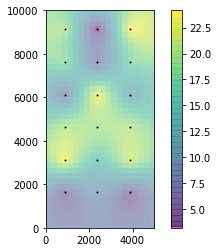

In [64]:
# plot
ax = plt.subplot(111,aspect='equal')
cb=ax.imshow(hk_arr,interpolation="nearest",extent=m.sr.get_extent(),alpha=0.5)
ax.scatter(df_pp.x,df_pp.y,marker='.',s=4,color='k')
plt.colorbar(cb)